In [1]:
! pip install -U chainer

Requirement already up-to-date: chainer in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: filelock in /usr/local/lib/python2.7/dist-packages (from chainer)
Requirement already up-to-date: protobuf>=2.6.0 in /usr/local/lib/python2.7/dist-packages (from chainer)
Requirement already up-to-date: numpy>=1.9.0 in /usr/local/lib/python2.7/dist-packages (from chainer)
Requirement already up-to-date: nose in /usr/local/lib/python2.7/dist-packages (from chainer)
Requirement already up-to-date: six>=1.9.0 in /usr/local/lib/python2.7/dist-packages (from chainer)
Requirement already up-to-date: setuptools in /usr/local/lib/python2.7/dist-packages (from protobuf>=2.6.0->chainer)


In [1]:
import chainer
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import chainer.functions as F
import chainer.links as L
import argparse
import math
from __future__ import division

In [2]:
print (chainer.__version__)

2.0.1


## 1. Load MNIST dataset

In [3]:
import os
from urllib import urlretrieve

def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# We then define functions for loading MNIST images and labels.
# For convenience, they also download the requested files if needed.
import gzip

def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    # The inputs are vectors now, we reshape them to monochrome 2D images,
    # following the shape convention: (examples, channels, rows, columns)
    data = data.reshape(-1, 1, 28, 28)
    # The inputs come as bytes, we convert them to float32 in range [0,1].
    # (Actually to range [0, 255/256], for compatibility to the version
    # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
    return data / np.float32(256)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the labels in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    # The labels are vectors of integers now, that's exactly what we want.
    return data

In [4]:
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

## 2. Numbers plot function

In [5]:
def plotSet(X,Y,N=0) :
    if N==0:
        N = len(X)
    total = N
    if (len(X) < N):
        N = len(X)
    if (len(Y) < N):
        N = len(Y)
    max_in_row = 25
    M = 1
    if N > max_in_row:
        M = int(math.ceil(N/max_in_row))
        N = max_in_row
    w = math.floor(1/N*1000)/1000    
    #w=0.1
    h = math.floor(1/(M) *1000)/1000
    #h=0.3
    #print N,M,w,h
    pad = 0
    fig = plt.figure(figsize=(N/1.5, M), dpi=120)    
    for j in range(M):
        for i in range(N):
            n = i+(j*N)+1 
            if n > total:
                break
            l = pad+(i+1)*(w+pad)
            b = pad+(j)*(h+pad)
            #print n,l,b,Y[n-1]
            #a = fig.add_axes([l, b, w, h])
            a = fig.add_subplot(M,N,n)
            a.imshow(X[n-1][0])
            a.axis('off')
            a.set_title(str(Y[n-1]),fontsize=10)
    #plt.tight_layout()

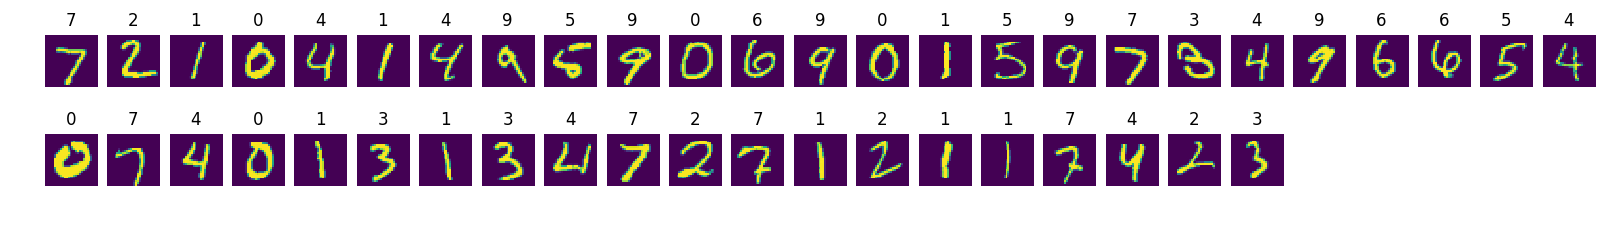

In [6]:
plotSet(X_test,y_test, 45)

# 3. Create model

In [118]:
class MLP(chainer.Chain):
    
    def __init__(self):
        super(MLP, self).__init__(
            l1 = L.Convolution2D(None, 32, (3,3)),
            l2 = L.Convolution2D(None, 32, (3,3)),
            l3 = L.Linear(None, 128),
            l4 = L.Linear(None, 10),
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.max_pooling_2d(h2, (2,2))
        h4 = F.dropout(h3, 0.25)
        #print "H4 shape:", h4.shape
        h5 = F.reshape(h4,(h4.shape[0],h4.shape[1]*h4.shape[2]*h4.shape[3]))
        h6 = F.relu(self.l3(h5))
        h7 = F.dropout(h6, 0.5)
        h8 = F.softmax(self.l4(h7))
        return h8


### Sample model in Keras
```
model.add(Conv2D(32, (3, 3), data_format="channels_first",activation='tanh',input_shape=(1,28,28)))
model.add(Conv2D(32, (3, 3)))
layer_2 = Activation('relu')
model.add(layer_2)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))
```

In [21]:
# Sample Model definition
class SampleModel(chainer.Chain):

    def __init__(self):
        super(SampleModel, self).__init__(
            l1 = L.Convolution2D(None, 32, (3,3)),
            l2 = L.Convolution2D(None, 32, (3,3)),
            l3 = L.Linear(None, 10),
        )

    def __call__(self, x):
        h = F.tanh(self.l1(x))
        h = F.relu(self.l2(h))
        h = F.max_pooling_2d(h, (2,2))
        h = F.reshape(h,(h.shape[0],h.shape[1]*h.shape[2]*h.shape[3]))
        h = F.dropout(h, 0.25)
        h = self.l3(h)
        h = F.relu(h)
        return h

# 4. Train model

###  Training parameters

In [22]:
n_epoches = 12
batchsize = 100
samples = 60000 # Samples for training
print X_train[:samples].shape

(60000, 1, 28, 28)


In [23]:
from chainer.datasets import tuple_dataset
traning_dataset = tuple_dataset.TupleDataset(X_train, y_train)
test_dataset = tuple_dataset.TupleDataset(X_test, y_test)
from chainer.dataset.convert import concat_examples

In [ ]:
def eval(model, X_test, y_test,batchsize):
    # Pick random indexes
    test_indexes = np.random.randint(0,y_test.shape[0], batchsize)
    x = X_test[test_indexes]
    t = y_test[test_indexes]

    y = model.predictor(x)
    y = y.data
    # y has predictions as probabilities
    h = np.asarray(decodeNum(y))
    # h has predictions as numbers

    errors = []
    for i in range(len(h)):
        if h[i] != t[i]:        
            errors.append(i)
            

# Training

Use classes: Optimizer - Classifier - SampleModel (custom model network).

For training use Optimizer.update() function.

In [16]:
model = L.Classifier(SampleModel(), lossfun = F.softmax_cross_entropy)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
train_iter = chainer.iterators.SerialIterator(traning_dataset[:samples], batchsize, repeat=False, shuffle=True)
test_iter = chainer.iterators.SerialIterator(test_dataset, batchsize,
                                                 repeat=False, shuffle=False)
model.cleargrads()
loss = []
acc = []
for x in train_iter:
    #print type(x)  x is a list
    x, t = concat_examples(x, -1)
    # print type(x[0]) x[0] is ndarray
    # print type(t[0]) type is numpy.uint8
    t = t.astype(np.int32)
    #print type(t[0]) type is int32    
    #plotSet(x,t)
    x = chainer.Variable(x)
    t = chainer.Variable(t)
    optimizer.update(model, x, t)
    print model.loss.data, model.accuracy.data
    loss.append(model.loss.data)
    acc.append(model.accuracy.data)
    if (test_condition):
        model(x, c, t, mode="test")
        print "validation:",model.loss, model.acc


2.30281209946 0.119999997318
2.28252768517 0.109999999404
2.25659441948 0.219999998808
2.23763251305 0.259999990463
2.19653701782 0.340000003576
2.13313984871 0.469999998808
2.14384913445 0.379999995232
2.0197365284 0.560000002384
1.98163414001 0.540000021458
1.92877030373 0.639999985695
1.86658155918 0.699999988079
1.80977010727 0.75
1.80066263676 0.740000009537
1.84273254871 0.670000016689
1.79061043262 0.699999988079
1.79617488384 0.699999988079
1.71443641186 0.75
1.72291076183 0.75
1.74613261223 0.759999990463
1.69143843651 0.800000011921
1.65522909164 0.870000004768
1.63500392437 0.850000023842
1.67601907253 0.800000011921
1.68097174168 0.810000002384
1.664970994 0.810000002384
1.64200437069 0.839999973774
1.62820732594 0.850000023842
1.65164077282 0.800000011921
1.61078453064 0.889999985695
1.67949414253 0.790000021458
1.59938406944 0.879999995232
1.67575728893 0.800000011921
1.61018812656 0.850000023842
1.6874383688 0.769999980927
1.60982728004 0.850000023842
1.5976537466 0.8700

1.49419021606 0.959999978542
1.51432669163 0.949999988079
1.53777098656 0.930000007153
1.50943386555 0.949999988079
1.51768708229 0.949999988079
1.4961783886 0.97000002861
1.49311339855 0.97000002861
1.51253795624 0.949999988079
1.51424050331 0.949999988079
1.52255654335 0.939999997616
1.50243604183 0.959999978542
1.53187990189 0.930000007153
1.50849688053 0.949999988079
1.50753581524 0.959999978542
1.50630486012 0.959999978542
1.50492560863 0.959999978542
1.49507963657 0.97000002861
1.51492798328 0.959999978542
1.50951611996 0.959999978542
1.49610602856 0.97000002861
1.52303493023 0.959999978542
1.51329708099 0.949999988079
1.47435665131 0.990000009537
1.4955919981 0.980000019073
1.50094079971 0.959999978542
1.51277923584 0.949999988079
1.51750195026 0.949999988079
1.4908028841 0.97000002861
1.53139078617 0.939999997616
1.51160860062 0.959999978542
1.51635324955 0.939999997616
1.50347268581 0.97000002861
1.50084412098 0.97000002861
1.52811324596 0.939999997616
1.50034630299 0.97000002

1.48150718212 0.980000019073
1.50439667702 0.959999978542
1.53329360485 0.939999997616
1.51092755795 0.959999978542
1.47172236443 0.990000009537
1.48167598248 0.980000019073
1.50647056103 0.949999988079
1.51015210152 0.949999988079
1.475238204 0.990000009537
1.49468553066 0.97000002861
1.48366999626 0.980000019073
1.50339341164 0.949999988079
1.5062443018 0.959999978542
1.49089205265 0.980000019073
1.49748170376 0.959999978542
1.48446524143 0.980000019073
1.50640106201 0.959999978542
1.51491928101 0.949999988079
1.50236940384 0.97000002861
1.51233839989 0.949999988079
1.51160335541 0.949999988079
1.48466992378 0.980000019073
1.53461885452 0.920000016689
1.49038434029 0.97000002861
1.49482250214 0.97000002861
1.48453688622 0.980000019073
1.52867722511 0.939999997616
1.48424994946 0.97000002861


In [19]:
def plot_loss_accuracy(loss, acc) :
    niter = len(loss)
    fig = plt.figure(figsize=(12, 7))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax1.plot(range(niter), loss, 'r-',label= "loss_train",alpha=0.4)
    ax2.plot(range(niter), acc, 'b-',label= "acc_train",alpha=0.7)
    ax1.set_ylim([0,2.5])
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('loss')
    ax2.set_ylabel('accuracy')

    ax2.set_ylim([0,1])
    ax1.legend(loc='lower left')
    ax2.legend(loc='lower right')
    ax1.minorticks_on()
    ax1.grid(which="both")
    plt.savefig("train_loss_acc.png")

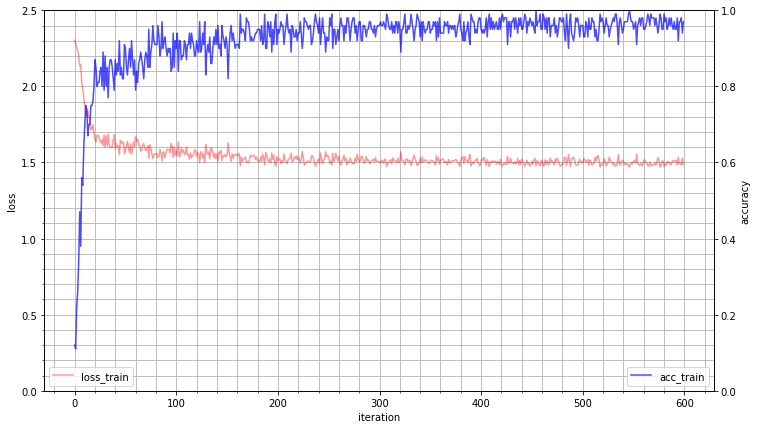

In [20]:
plot_loss_accuracy(loss,acc)

In [152]:
def decodeNum(x):
    i = []
    for xi in x:
        ni = np.argmax(xi)
        i.append(ni)
    return i

## 5. Predictions

9 ≠ 8
7 ≠ 3


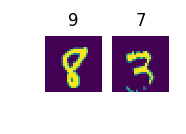

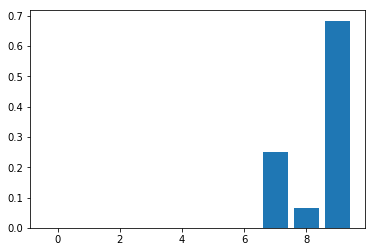

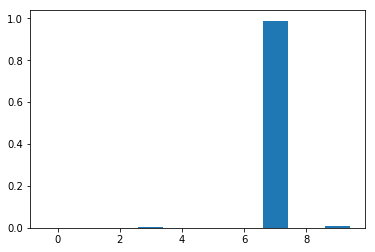

In [214]:
# Pick random indexes
test_indexes = np.random.randint(0,y_test.shape[0], batchsize)
x = X_test[test_indexes]
t = y_test[test_indexes]

y = model.predictor(x)
y = y.data
# y has predictions as probabilities
h = np.asarray(decodeNum(y))
# h has predictions as numbers

errors = []
for i in range(len(h)):
    if h[i] != t[i]:        
        errors.append(i)

# errors has indexes of incorrect redictions
for i in errors:
    print h[i],"≠", t[i]

# plot images and predictions (incorrect)
plotSet(x[errors],h[errors])

# Plot probabilities
y_err = y[errors]
for i in range(len(y_err)):
    fig = plt.figure()
    plt.bar(range(len(y_err[i])), y_err[i])